## Neural Style Transfer with Perceptual Loss

This notebook is a demonstration of neural style transfer with pytorch and deep learning. We will use the perceptual loss in order to apply the style of a "style image" to a "content image".

For doing so, I had learned from the following paper and posts:
* https://arxiv.org/pdf/1603.08155.pdf
* https://towardsdatascience.com/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916
* https://medium.com/@sashankpappu/style-transfer-using-pytorch-cb6225cf183e

Importing the required libraries:

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.optim as optim
from torchvision import transforms, models

A vgg19 as our pretrained model:

In [67]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device);

A function to load an image and change it to a tensor:

In [68]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size: size = max_size
    else: size = max(image.size) 
    if shape is not None: size = shape       
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

A function to change a torch tensor to a numpy image:

In [69]:
def im_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

A function to get specific features from our pretrained model:

In [70]:
def get_features(image, model, layers=None):

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

A function to generate a gram matrix for a given tensor:

In [71]:
def gram_matrix(tensor):
    
    b, c, h, w = tensor.size()
    tensor = tensor.view(b * c, -1)
    gram = torch.mm(tensor, tensor.t())
    
    return gram

The main training function:

In [72]:
def train_model(content, style, steps=20000, save_every=500, content_weight = 1, style_weight = 250):
    
    # get content and style features only once before training
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)

    # calculate the gram matrices for each layer of our style representation
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # create a third "target" image (starting with a copy of our content image) and prep it for change
    target = content.clone().requires_grad_(True).to(device)
    
    # iteration hyperparameters
    save_every = save_every
    optimizer = optim.Adam([target], lr=0.003)
    steps = steps
    
    # I am weighting the deeper features higher to intensify their presence in the target image
    style_weights = {
        'conv1_1': 1,
        'conv2_1': 1,
        'conv3_1': 1,
        'conv4_1': 10,
        'conv4_2': 20,
        'conv5_1': 25,
    }
    content_weight = content_weight
    style_weight = style_weight
    
    # A list to save intermediate images
    img_list = []
    
    for ii in tqdm(range(1, steps+1)):

        # get the features from your target image
        target_features = get_features(target, vgg)

        # the content loss
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        # the style loss initialized at 0
        style_loss = 0
        # then add to it for each layer's gram matrix loss
        for layer in style_weights:
            # get the "target" style representation for the layer
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, c, h, w = target_feature.shape
            
            # get the "style" representation and weight it for each layer
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (c * h * w)

        # calculate the total loss
        total_loss = content_weight * content_loss + style_weight * style_loss

        # update the target image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # save intermediate images and print the loss
        if  ii % save_every == 0: img_list.append(im_convert(target))
        
    return img_list

A function to plot the original and generated images:

In [73]:
def show_results(content, style, img_list):
    fig, axes = plt.subplots(3, 2, figsize=(20, 20))
    axes[0, 0].imshow(im_convert(content))
    axes[0, 1].imshow(im_convert(style))
    for i in range(4):
        axes[1 + i//2, i%2].imshow(img_list[i])

The main function:

100%|██████████| 20000/20000 [06:46<00:00, 49.19it/s]


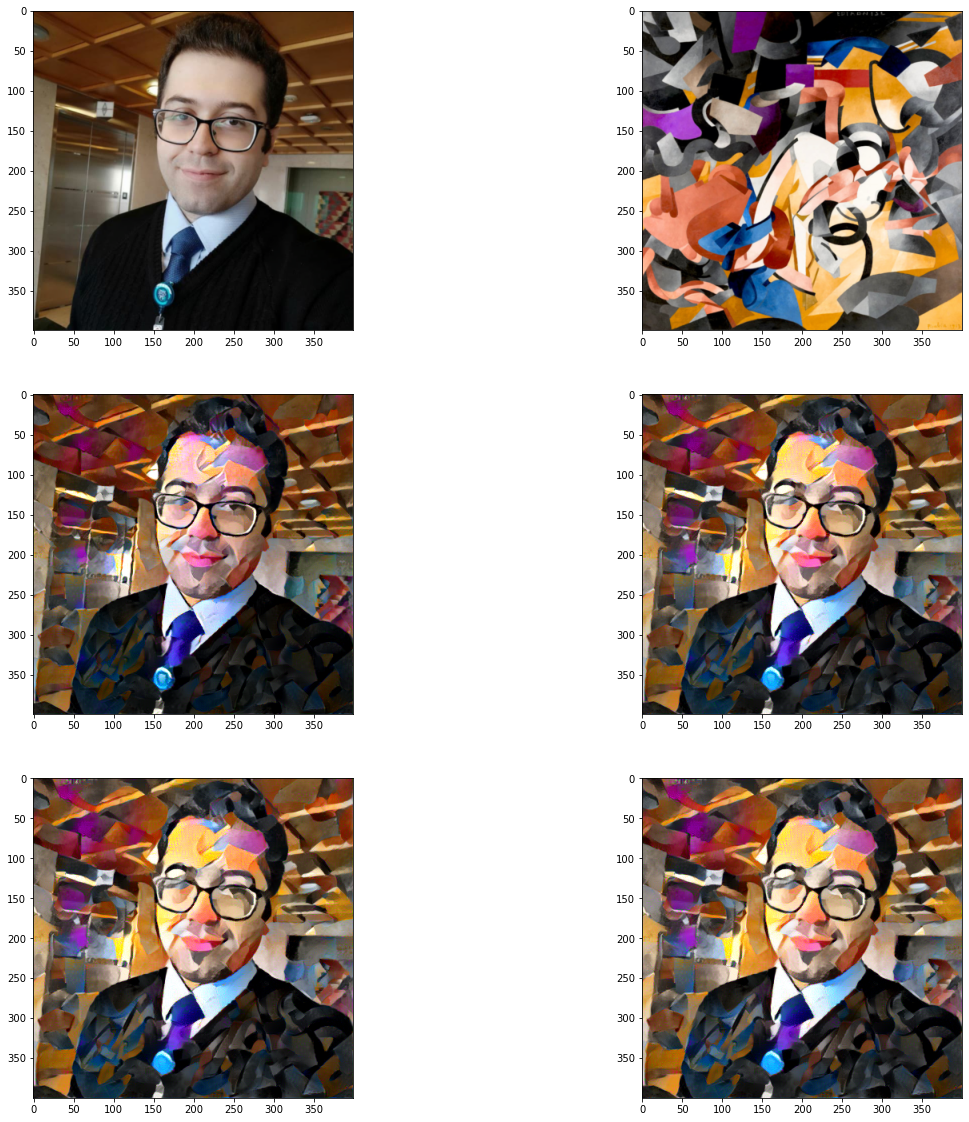

In [46]:
def main():
    content = load_image('../0_Data/Pouria/Pouria_1.jpg').to(device)
    style = load_image('../0_Data/Pouria/Style_1.jpg', shape=content.shape[-2:]).to(device)
    img_list = train_model(content, style, save_every=5000, content_weight=1, style_weight=500)
    show_results(content, style, img_list)
main()